## Shakespeak: Usage Demo

In [6]:
from utils import Args
from train import Training

### Training a Simple Model

In [7]:
args = Args()                                   # see Args object for default parameters
args.max_iter = 30
args.val_int = 25                               # compute validation loss every 25 grad steps

print("Default arguments : \n--------------------------\n", 
      args, '\n--------------------------')

train = Training(args)                          # training run takes a bag of parameters 
default_model, def_train_loss, def_valid_loss = train.train()

Default arguments : 
--------------------------
 Args(batch_size=10, n_tokens=64, n_layers=4, n_heads=4, d_model=128, use_lr_decay=True, lr=0.001, dataset_path='./datasets/shakespear_corpus.txt', max_iter=30, out_dir='./runs/', n_warm_iters=100, lr_decay_iter=5000, min_lr=0.0001, n_validation_batch=200, betas=(0.9, 0.99), n_epochs=10, val_int=25, save=True, save_int=200, name='milkshake', cross_val=False, k_fold=10) 
--------------------------
Epoch: 0, Batch index 0, Training Loss: 4.3097, Validation Loss: 4.2808
Epoch: 0, Batch index 25, Training Loss: 3.5009, Validation Loss: 3.3887


### Generating Text

In [3]:
from utils import generate

print(generate(default_model, train.tokenized_data, "POMPEY:", 150))

POMPEY:is sZS Fyont uBDuw 
zT  $3eTe fyPaKclPwteeTs d
deT
uiZrOesf
orBF?nhuDhehenet Fn Zl X
iFe-nY nS sa -ZqveeQ'iIi' g t nh rOieet s sP tagroyahil?uBoC ,rll


### Loading a Pretrained Model

In [4]:
from utils import load_model_metrics, generate

long_model, long_model_params, long_train_loss, long_valid_loss = load_model_metrics(
    "./runs/long_model_b128_t256_l16_h16_d256_0_5000.pt",
    train.tokenized_data.vocabulary_size)

In [5]:
print(generate(long_model, train.tokenized_data, "Wherefore did they not", 150))

Wherefore did they not?

QUEEN MARGARET:
Nay, I know not heaven for our state mine,
Have with some punish'd with my teeting from the wrong
Of soldiers: nor hours and heavin


### Plotting Training Loss at Every Gradient Step

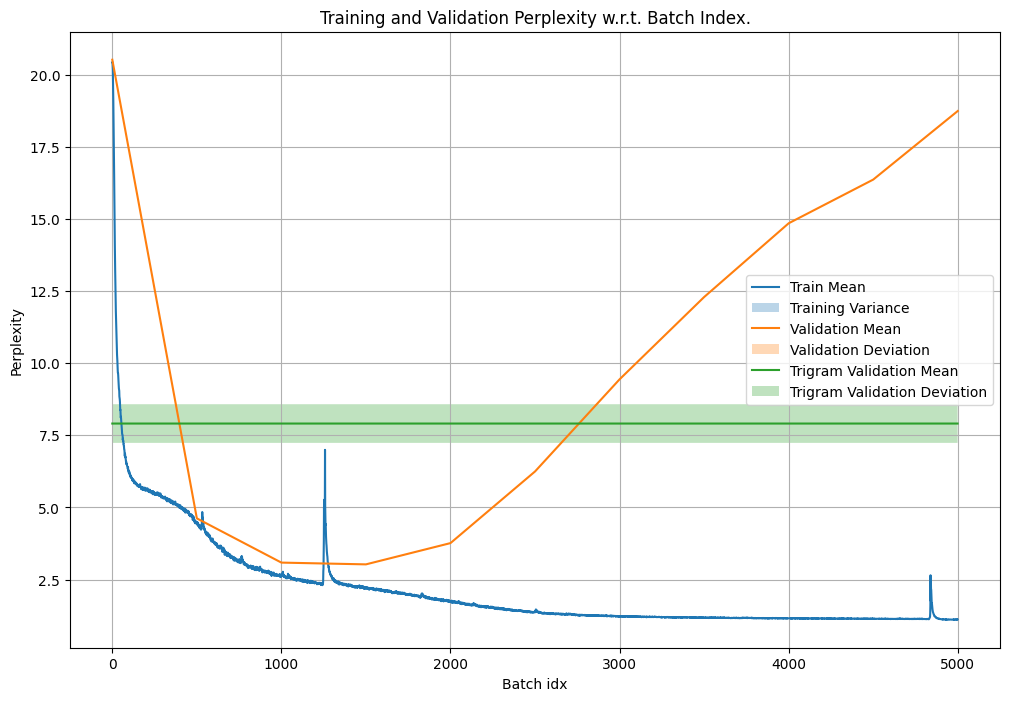

In [6]:
from utils import perplexity_graph

perplexity_graph(
    # note, we unsqueeze for the function expects a (k_fold, n_batch) tensor
    long_train_loss.unsqueeze(0), long_valid_loss.unsqueeze(0),     
    val_int=long_model_params['val_int'], name="long_model", args=long_model_params          
)

Textbook example of overfitting. The spikes are typical of stochastic gradient descent (of which Adam hails from).

### Cross-Validation Run Plotting

In [7]:
import torch
from utils import perplexity_graph

dict_keys(['k_fold_train_loss', 'k_fold_valid_loss', 'params'])


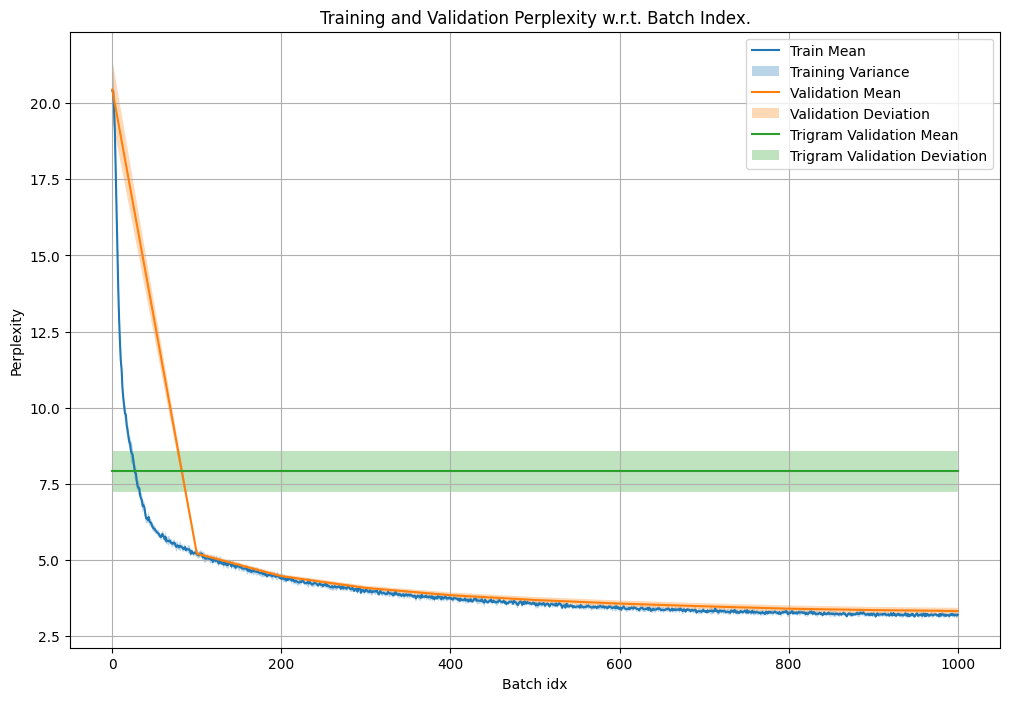

In [8]:
# load cross validation recap file.
cross_val_run = torch.load(f'./simulation_results/Sim_b128_t16_l8_h8_d256/total_cross_val_metrics.pt')   
print(cross_val_run.keys())

perplexity_graph(
    cross_val_run['k_fold_train_loss'], cross_val_run['k_fold_valid_loss'], 
    val_int=cross_val_run['params']['val_int'], name="Large window small model", 
    args=cross_val_run['params']          
)

Note, here the number of folds was 10, and the standard deviation for validation / train losses was very small, the surfaces are barely visible. A more visible example on a smaller number of steps is provided below. Cell below takes ~2 min on 8 core CPU to execute.

In [19]:
print(args)
args.val_int = 15
args.n_layers = 2
args.n_heads = 2
args.k_fold = 15
args.max_iter = 200
args.d_model = 42
small_train = Training(args)

models, train_loss, val_loss = small_train.cross_validation()   # ~2m20s minutes execution on 8 core CPU

Args(batch_size=10, n_tokens=64, n_layers=2, n_heads=2, d_model=42, use_lr_decay=True, lr=0.001, dataset_path='./datasets/shakespear_corpus.txt', max_iter=200, out_dir='./runs/', n_warm_iters=100, lr_decay_iter=5000, min_lr=0.0001, n_validation_batch=200, betas=(0.9, 0.99), n_epochs=10, val_int=15, save=True, save_int=200, name='milkshake', cross_val=False, k_fold=15)
---------------------------------
Fold n°0
Epoch: 0, Batch index 0, Training Loss: 4.4227, Validation Loss: 4.4600
Epoch: 0, Batch index 15, Training Loss: 4.3898, Validation Loss: 4.3574
Epoch: 0, Batch index 30, Training Loss: 4.1317, Validation Loss: 4.0823
Epoch: 0, Batch index 45, Training Loss: 3.7554, Validation Loss: 3.7183
Epoch: 0, Batch index 60, Training Loss: 3.4854, Validation Loss: 3.4321
Epoch: 0, Batch index 75, Training Loss: 3.2720, Validation Loss: 3.2763
Epoch: 0, Batch index 90, Training Loss: 3.3449, Validation Loss: 3.1853
Epoch: 0, Batch index 105, Training Loss: 3.1096, Validation Loss: 3.0715
Ep

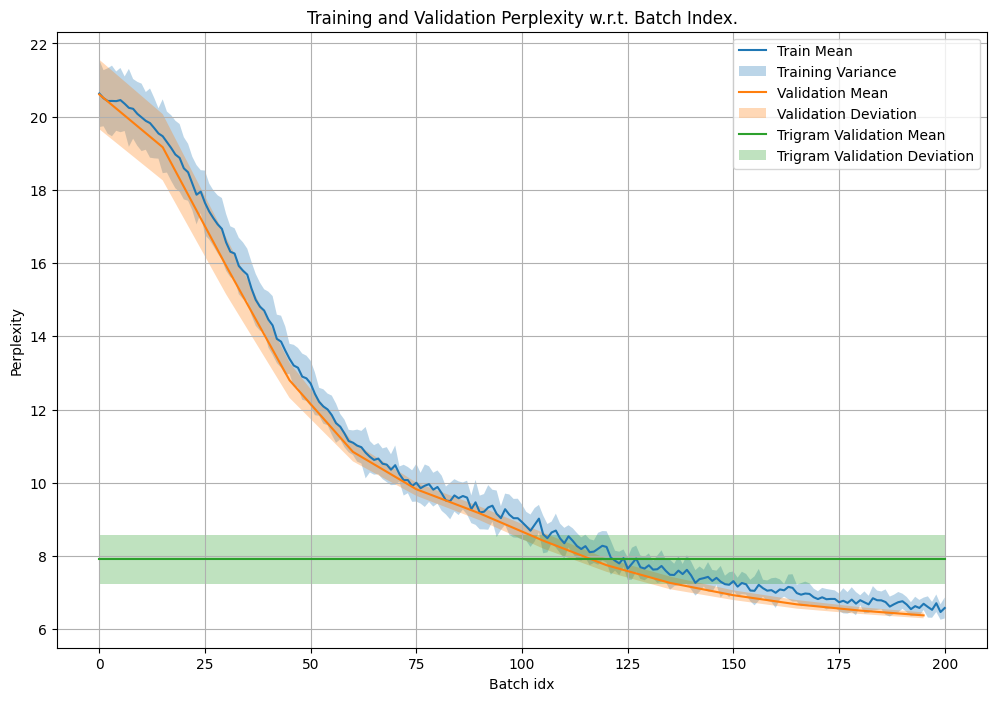

In [20]:
perplexity_graph(
    train_loss, val_loss, 
    val_int=args.val_int, name="Small Model Test", 
    args=args.__dict__
)

Note that this is only for 200 batches. The model may very well overfit on a larger amount of iterations. 

### Baseline Computation : Bigram and Trigram Model

In [14]:
from N_gram import cross_val_ngram 

perx_val_mean2, perx_val_std2 = cross_val_ngram(2, 10, './datasets/shakespear_corpus.txt', 128)
print("Bigram Perplexity Mean :", perx_val_mean2, "Perplexity std :", perx_val_std2)

perx_val_mean3, perx_val_std3 = cross_val_ngram(3, 10, './datasets/shakespear_corpus.txt', 128)
# these are the values plotted in perplexity_graph
print("Trigram Perplexity Mean :", perx_val_mean3, "Perplexity std :", perx_val_std3)           

Bigram Perplexity Mean : 11.97327709197998 Perplexity std : 0.17396734654903412
Trigram Perplexity Mean : 7.911648750305176 Perplexity std : 0.6726226806640625


See the `N_gram.py` for examples of text generation. No they're not as good as a large well trained model.  